## PCA를 통한 주식 시장 분석 

### KOSPI200 종목 data 를 sklearn.decomposition 을 통해 PCA 분석

- PCA를 일일 주식 수익률에 적용할 때 첫 번째 주성분은 시장 요인(beta)에 근사합니다.

In [1]:
#!pip install pykrx

In [2]:
import os
import os.path
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import FinanceDataReader as fdr
from pykrx import stock
from sklearn.decomposition import PCA
import korean

In [3]:
# 코스피200 ticker 및 지수 가져오기
with open('./data/kospi200tickers.pickle', 'rb') as f:
    tickers = pickle.load(f)   

- `{ticker: name}` dictionary  작성

In [4]:
ticker_to_name = {}

for ticker in tickers:
    ticker_to_name[ticker[0]] = ticker[1]

2020-01-01 ~ 2020-12-31 기간 KOSPI200 종목의 주가 정보 수집

In [5]:
%%time
main_df = pd.DataFrame()
start = '2020-01-01'
end = '2021-01-01'

for ticker in tickers:
    df = fdr.DataReader(ticker[0], start=start, end=end)
    df.rename(columns={'Close': ticker[1]}, inplace=True)
    main_df =  pd.concat([main_df, df[ticker[1]]], axis=1)
            
print(main_df.shape)
main_df.head()

(248, 200)
CPU times: total: 1.27 s
Wall time: 25.7 s


,삼성전자,SK하이닉스,NAVER,삼성바이오로직스,카카오,LG화학,삼성SDI,현대차,기아,카카오뱅크,...,동원F&B,LX홀딩스,넥센타이어,쿠쿠홀딩스,SNT모티브,삼양식품,현대두산인프라코어,롯데하이마트,일양약품,LX하우시스
2020-01-02 00:00:00,55200,94700,182500,423485,30609,314000,232000,118000,42500,NaN,...,223500,NaN,8900,20700,43600,89100,4655,30600,22850,54900
2020-01-03 00:00:00,55500,94500,181500,417061,30609,311000,229000,116000,42000,NaN,...,222500,NaN,8950,20900,43550,92600,4646,30400,22650,55500
2020-01-06 00:00:00,55500,94300,180500,407178,31010,307000,230000,116000,41900,NaN,...,218000,NaN,8890,20500,42400,92400,4494,29500,21850,54600
2020-01-07 00:00:00,55800,94000,187000,414096,32114,311000,231500,115500,42050,NaN,...,220000,NaN,8790,20600,42650,98000,4460,30100,22000,55900
2020-01-08 00:00:00,56800,97400,183000,403719,32014,302000,229000,112000,41300,NaN,...,219500,NaN,8560,20700,40800,97400,4266,28600,20650,53900


### null data cleansing  
- start 일 이후 상장한 종목이 있으므로 이전 날짜는 back fill 로 채움 
- 전체가 NaN (기간 중 상장 않은 종목)인 종목은 drop

In [6]:
main_df.loc[:, main_df.isnull().sum() > 0]

,카카오뱅크,크래프톤,SK바이오사이언스,하이브,SK아이이테크놀로지,SK바이오팜,DL이앤씨,LX홀딩스
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-23,NaN,NaN,NaN,151470.0,NaN,171000.0,NaN,NaN
2020-12-24,NaN,NaN,NaN,156420.0,NaN,171000.0,NaN,NaN
2020-12-28,NaN,NaN,NaN,154935.0,NaN,167500.0,NaN,NaN
2020-12-29,NaN,NaN,NaN,156915.0,NaN,168000.0,NaN,NaN


In [7]:
prices = main_df.copy()

prices.fillna(method="bfill", inplace=True)

prices.loc[:, prices.isnull().sum() > 0]

,카카오뱅크,크래프톤,SK바이오사이언스,SK아이이테크놀로지,DL이앤씨,LX홀딩스
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-12-23,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-24,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,NaN,NaN,NaN,NaN,NaN,NaN


전체가 NaN인 종목은 drop

In [8]:
prices.dropna(axis=1, inplace=True)
prices.shape

(248, 194)

## Asset의 daily Return(일일 수익률) 계산 

- 주가 크기가 서로 다르므로 log 함수 적용 
- log 를 적용했으므로 pct_change() 대신 diff() 적용

In [9]:
returns = prices.apply(np.log).diff(1)
returns.head(3)

,삼성전자,SK하이닉스,NAVER,삼성바이오로직스,카카오,LG화학,삼성SDI,현대차,기아,셀트리온,...,현대홈쇼핑,동원F&B,넥센타이어,쿠쿠홀딩스,SNT모티브,삼양식품,현대두산인프라코어,롯데하이마트,일양약품,LX하우시스
2020-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 00:00:00,0.00542,-0.002114,-0.005495,-0.015286,0.000000,-0.009600,-0.013015,-0.017094,-0.011834,-0.013992,...,0.009975,-0.004484,0.005602,0.009615,-0.001147,0.038530,-0.001935,-0.006557,-0.008791,0.010870
2020-01-06 00:00:00,0.00000,-0.002119,-0.005525,-0.023982,0.013016,-0.012945,0.004357,0.000000,-0.002384,-0.025673,...,-0.028951,-0.020432,-0.006726,-0.019324,-0.026761,-0.002162,-0.033263,-0.030052,-0.035959,-0.016349


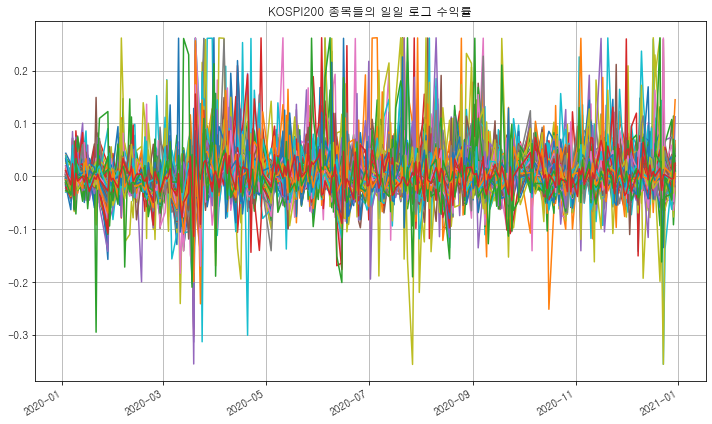

In [10]:
returns.plot(title="KOSPI200 종목들의 일일 로그 수익률", legend=False, 
             figsize=(10,6), grid=True);
plt.tight_layout()

- 누적 수익률 계산  
- log 수익률이므로 prod() 대신 cumsum()으로 더해줌  
- 원래의 값으로 복원하려면 np.exp() 적용

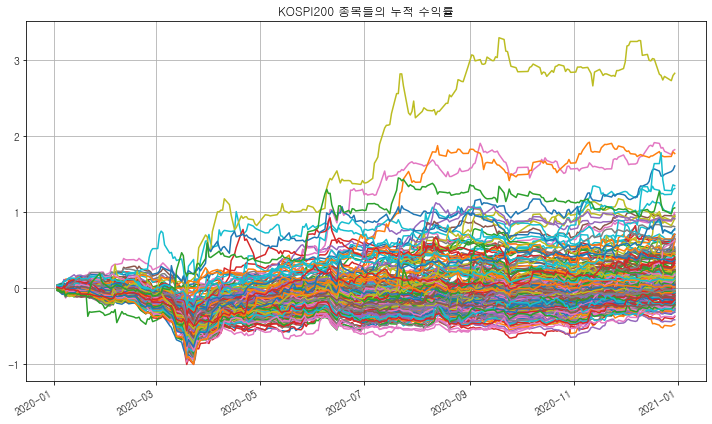

In [11]:
crs = returns.cumsum()#.apply(np.exp)

crs.plot(title="KOSPI200 종목들의 누적 수익률", legend=False,
         figsize=(10,6), grid=True)
plt.tight_layout()

위의 수치는 2020년  이후 KOSPI200 지수 500개 종목의 일일 수익률과 누적 수익률을 보여줍니다. 원시 데이터의 양이 상당히 많아 보일 수 있으므로 PCA를 통해 일일 수익률의 첫 번째 주성분을 계산하여 처리해 보겠습니다.

아래 그림은 기본적으로 200개 주식 각각에 대한 값을 포함하는 차원 200의 벡터인 첫 번째 주성분의 값을 보여줍니다.

In [12]:
pca = PCA(n_components=1)
pca.fit(returns.fillna(0))

pc1 = pd.Series(index=returns.columns, data=pca.components_[0])
pc1.head()

삼성전자       -0.051404
SK하이닉스     -0.056886
NAVER      -0.034765
삼성바이오로직스   -0.045961
카카오        -0.037971
dtype: float64

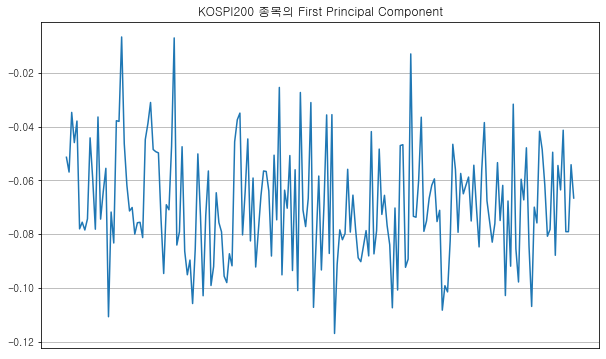

In [13]:
pc1.plot(title='KOSPI200 종목의 First Principal Component', 
         figsize=(10,6), xticks=[], grid=True);

첫 번째 주성분은 대부분의 분산을 설명하는 입력 데이터의 선형 조합을 나타내고, 주식 수익률의 주요 동인은 전체 시장 요인이므로, 첫 번째 주성분(즉, 입력 데이터의 선형 결합)에 비례하여 현금을 할당해 주식 포트폴리오를 구성하면 KOSPI200의 수익률을 대략적으로 복제할 수 있음을 의미합니다.

In [14]:
weights = abs(pc1) / sum(abs(pc1))
weights.sum()

1.0

첫번째 주성분 비율로 구성한 200개 종목 portfolio 의 daily log return

In [15]:
my_portfolio = (weights * returns).sum(axis=1)
my_portfolio

2020-01-02    0.000000
2020-01-03   -0.000368
2020-01-06   -0.018792
2020-01-07    0.008516
2020-01-08   -0.028819
                ...   
2020-12-23    0.000121
2020-12-24    0.010100
2020-12-28   -0.002207
2020-12-29    0.004013
2020-12-30    0.014369
Length: 248, dtype: float64

my_portfolio의 누적 수익률

<AxesSubplot:>

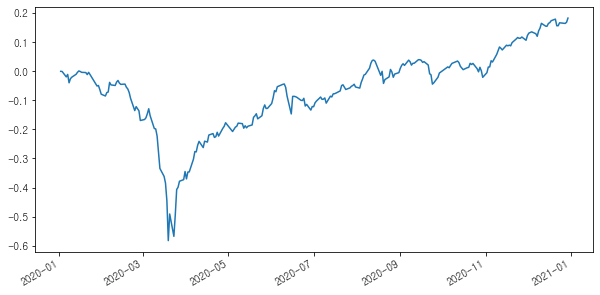

In [16]:
my_portfolio.cumsum().plot()

아래 그림은 PCA 첫번째 주성분 portfolio가 KOSPI200을 거의 비슷하게 복제함을 보여줍니다.

In [18]:
kospi200 = stock.get_index_ohlcv(start, end, "1028")
kospi200 = kospi200.apply(np.log).diff()
kospi200.rename(columns={"종가": "Close"}, inplace=True)
kospi200

코스피 200,시가,고가,저가,Close,거래량,거래대금,상장시가총액
날짜,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.003712,0.001052,-0.003178,0.001342,0.187094,0.174810,0.000625
2020-01-06,-0.018491,-0.018724,-0.005377,-0.007977,-0.131331,-0.225708,-0.009119
2020-01-07,0.007893,0.009799,0.007451,0.009661,-0.068169,0.056943,0.010050
2020-01-08,-0.003696,-0.004286,-0.008112,-0.006234,0.644852,0.575577,-0.009354
...,...,...,...,...,...,...,...
2020-12-23,-0.011001,0.000054,-0.004678,0.013257,0.016731,0.151305,0.011331
2020-12-24,0.012590,0.022228,0.018876,0.020947,0.060134,0.003494,0.019262
2020-12-28,0.026131,0.009292,0.018051,0.001976,-0.032458,0.234195,0.001448


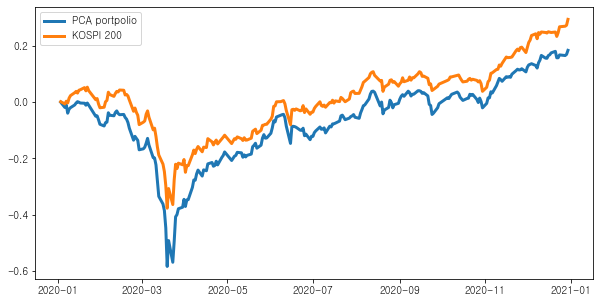

In [19]:
rs_df = pd.concat([my_portfolio, kospi200['Close']], axis=1)
rs_df.columns = ["PCA Portfolio", "KOSPI200"]
rs_df = rs_df.dropna().cumsum()

plt.figure(figsize=(10, 5))
plt.plot(rs_df["PCA Portfolio"], linewidth=3, label="PCA portpolio")
plt.plot(rs_df['KOSPI200'], linewidth=3, label="KOSPI 200")
plt.legend()

## PCA로 COVID19의 종목별 영향 분석

PCA를 사용하면 사전 지식 없이 COVID19 대유행의 영향을 가장 많이 받거나 적게 받은 비즈니스를 함께 클러스터링할 수 있습니다.

2020년은 COVID19 대유행으로 인해 주식 시장에 격변의 시기였습니다. PCA를 사용하여 이 대유행이 개별 주식에 어떤 영향을 미쳤는지 분석할 수 있습니다.


첫 번째 주성분을 살펴보고 아래와 같이 PCA 가중치가 가장 크거나 가장 작은 종목을 선택합니다.

In [20]:
pc1

삼성전자        -0.051404
SK하이닉스      -0.056886
NAVER       -0.034765
삼성바이오로직스    -0.045961
카카오         -0.037971
               ...   
삼양식품        -0.041368
현대두산인프라코어   -0.078990
롯데하이마트      -0.078994
일양약품        -0.054157
LX하우시스      -0.066514
Length: 194, dtype: float64

pca 가 가장 negative한 종목들

In [21]:
pc1.nsmallest(5)

OCI       -0.116732
SK이노베이션   -0.110526
동국제강      -0.108093
현대위아      -0.107212
팬오션       -0.107049
dtype: float64

pca가 가장 덜 negative한 종목들

In [22]:
pc1.nlargest(5)

하이브      -0.006795
SK바이오팜   -0.007148
농심       -0.013080
동서       -0.025506
CJ대한통운   -0.027383
dtype: float64

pca가 가장 negative한 종목(negative beta, 시장 영향을 많이 받은 종목)과 덜 negative한 종목(시장 영향을 적게 받은 종목) 시각화

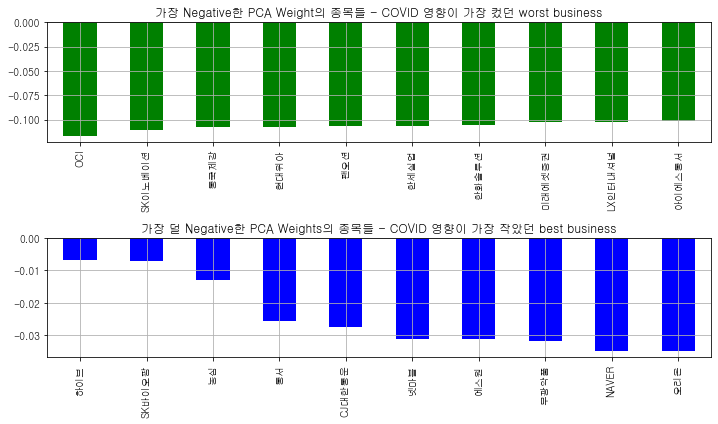

In [23]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], 
                       color='green', grid=True, 
    title='가장 Negative한 PCA Weight의 종목들 - COVID 영향이 가장 컸던 worst business')
pc1.nlargest(10).plot.bar(ax=ax[1], 
                      color='blue', grid=True, 
    title='가장 덜 Negative한 PCA Weights의 종목들 - COVID 영향이 가장 작았던 best business')

plt.tight_layout()

우리는 PCA 가중치에 따라 상위 및 하위 10개 기업을 매수한 포트폴리오를 구성할 수 있습니다. 아래 그림에서 볼 수 있듯이 이 하위 10 종목 포트폴리오는 KOSPI200 지수보다 더 손실을 본 반면, 상위 10 종목 포트폴리오는 팬데믹으로 인해 실제로 수혜를 입은 회사에 투자했기 때문에 시장보다 훨씬 더 나은 성과를 거두었을 것입니다.

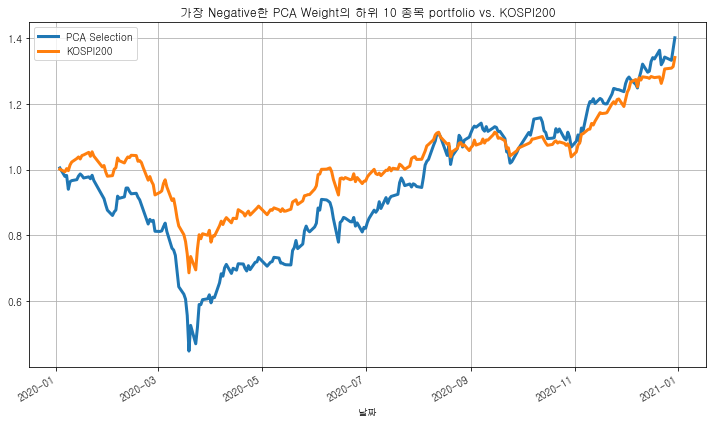

In [24]:
myrs = returns[pc1.nsmallest(10).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), 
                    grid=True, linewidth=3, 
    title='가장 Negative한 PCA Weight의 하위 10 종목 portfolio vs. KOSPI200')
kospi200['Close'].cumsum().apply(np.exp).plot(figsize=(10,6), 
                                              grid=True, linewidth=3)
plt.legend(['PCA Selection', 'KOSPI200'])
plt.tight_layout()

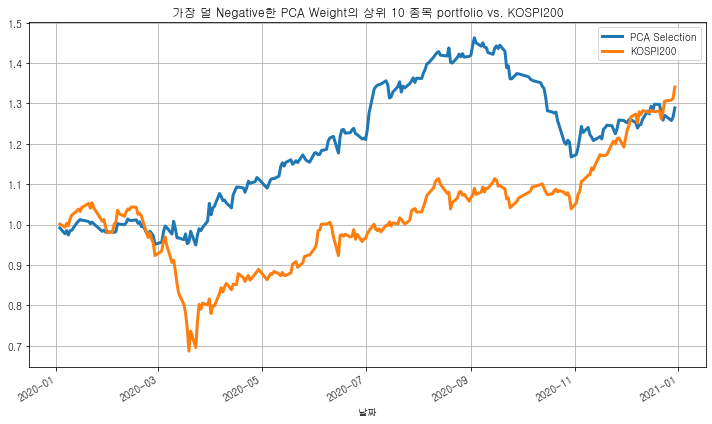

In [25]:
myrs = returns[pc1.nlargest(10).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), 
                grid=True, linewidth=3, 
title='가장 덜 Negative한 PCA Weight의 상위 10 종목 portfolio vs. KOSPI200')
kospi200['Close'].cumsum() \
        .apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'KOSPI200'])
plt.tight_layout()